In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from librep.datasets.har.loaders import (
    MotionSense_BalancedView20HZ
)

2022-11-11 17:30:07.363278: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-11 17:30:07.378083: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
from librep.transforms.topo_ae import (
    TopologicalDimensionalityReduction,
    CustomTopoDimRedTransform
)
from librep.transforms import UMAP
from sklearn.manifold import TSNE
from experiments.Topological_ae.Experiment_utils import *
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [6]:
# MotionSense Loader
loader = MotionSense_BalancedView20HZ(
    root_dir="../../../data/views/MotionSense/balanced_view_20Hz_with_gravity_9.81_acc_standard", 
    download=False
)

# Print the readme (optional)
loader.print_readme()

# Balanced MotionSense View Resampled to 20Hz with Gravity - Multiplied acc by 9.81m/s²

This is a view from [MotionSense] that was spllited into 3s windows and was resampled to 20Hz using the [FFT method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html#scipy.signal.resample). 

The data was first splitted in three sets: train, validation and test. Each one with the following proportions:
- Train: 70% of samples
- Validation: 10% of samples
- Test: 20% of samples

After splits, the datasets were balanced in relation to the activity code column, that is, each subset have the same number of activitiy samples.

**NOTE**: Each subset contain samples from distinct users, that is, samples of one user belongs exclusivelly to one of three subsets.

## Activity codes
- 0: downstairs (569 train, 101 validation, 170 test) 
- 1: upstairs (569 train, 101 validation, 170 test) 
- 2: sitting (569 train, 101 validation, 170 test) 
- 3: standing (569 train, 101 validation, 170 test) 
- 4: walking (569 train, 101 validation, 170 test) 
- 5: jogging (569 train, 101 validation, 170 test) 
 

## Standartized activity codes
- 0: sit (569 train, 101 validation, 170 test) 
- 1: stand (569 train, 101 validation, 170 test) 
- 2: walk (569 train, 101 validation, 170 test) 
- 3: stair up (569 train, 101 validation, 170 test) 
- 4: stair down (569 train, 101 validation, 170 test) 
- 5: run (569 train, 101 validation, 170 test) 
      




In [7]:
# Load the dataset
# If concat_train_validation is true, return a tuple (train+validation, test)
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val, test

(PandasMultiModalDataset: samples=4020, features=360, no. window=6, label_columns='standard activity code',
 PandasMultiModalDataset: samples=1020, features=360, no. window=6, label_columns='standard activity code')

In [8]:
train_HD = np.array(train_val[:][0])
train_Y = np.array(train_val[:][1])
test_HD = np.array(test[:][0])
test_Y = np.array(test[:][1])

In [9]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 360) (4020,) (1020, 360) (1020,)


# Aplicar FFT

In [10]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(
    transforms=[fft_transform],
    new_window_name_prefix="fft."
)

In [11]:
train_dataset_fft = transformer(train_val)
test_dataset_fft = transformer(test)

In [12]:
print(train_dataset_fft.X.shape)
print(test_dataset_fft.X.shape)

(4020, 180)
(1020, 180)


In [13]:
print(np.max(train_dataset_fft.X))

797.3368276806895


In [14]:
train_HD = train_dataset_fft.X
train_LD = None
train_Y = train_dataset_fft.y
test_HD = test_dataset_fft.X
test_LD = None
test_Y = test_dataset_fft.y

In [15]:
print(train_HD.shape, train_Y.shape, test_HD.shape, test_Y.shape)

(4020, 180) (4020,) (1020, 180) (1020,)


# Visualization helper

In [16]:
# 0: sit (569 train, 101 validation, 170 test)
# 1: stand (569 train, 101 validation, 170 test)
# 2: walk (569 train, 101 validation, 170 test)
# 3: stair up (569 train, 101 validation, 170 test)
# 4: stair down (569 train, 101 validation, 170 test)
# 5: run (569 train, 101 validation, 170 test)
def visualize(X, Y):
    labels = ['sit', 'stand', 'walk', 'stair up', 'stair down', 'run']
    df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=Y))
    groups = df.groupby('label')
    fig, ax = plt.subplots()
    ax.margins(0.05)
    for name, group in groups:
        ax.plot(group.x, group.y, marker='.', linestyle='', ms=8, label=labels[name])
    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

In [17]:
# Variables to reuse
model_dim = 10
model_epc = 125

# Reducing with Generic Autoencoders

In [18]:
model_lam = 0
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:500.3427, Loss-ae:500.3427, Loss-topo:476.6563
Epoch:2, P:None, Loss:381.7287, Loss-ae:381.7287, Loss-topo:590.4533
Epoch:3, P:None, Loss:309.3767, Loss-ae:309.3767, Loss-topo:660.6442
Epoch:4, P:None, Loss:287.5721, Loss-ae:287.5721, Loss-topo:677.0141
Epoch:5, P:None, Loss:267.4484, Loss-ae:267.4484, Loss-topo:856.8109
Epoch:6, P:None, Loss:273.0469, Loss-ae:273.0469, Loss-topo:954.7611
Epoch:7, P:None, Loss:246.3428, Loss-ae:246.3428, Loss-topo:907.7782
Epoch:8, P:None, Loss:219.9106, Loss-ae:219.9106, Loss-topo:1680.2121
Epoch:9, P:None, Loss:192.7521, Loss-ae:192.7521, Loss-topo:2376.6885
Epoch:10, P:None, Loss:174.8452, Loss-ae:174.8452, Loss-topo:2666.6586
Epoch:11, P:None, Loss:161.5873, Loss-ae:161.5873, Loss-topo:2612.6515
Epoch:12, P:None, Loss:158.6349, Loss-ae:158.6349, Loss-topo:3425.1460
Epoch:13, P:None, Loss:146.0892, Loss-ae:146.0892, Loss-topo:3530.2739
Epoch:14, P:None, Loss:139.1332, Loss-ae:139.1332, Loss-topo:3578.3986
Epoch:15, P:None, Loss

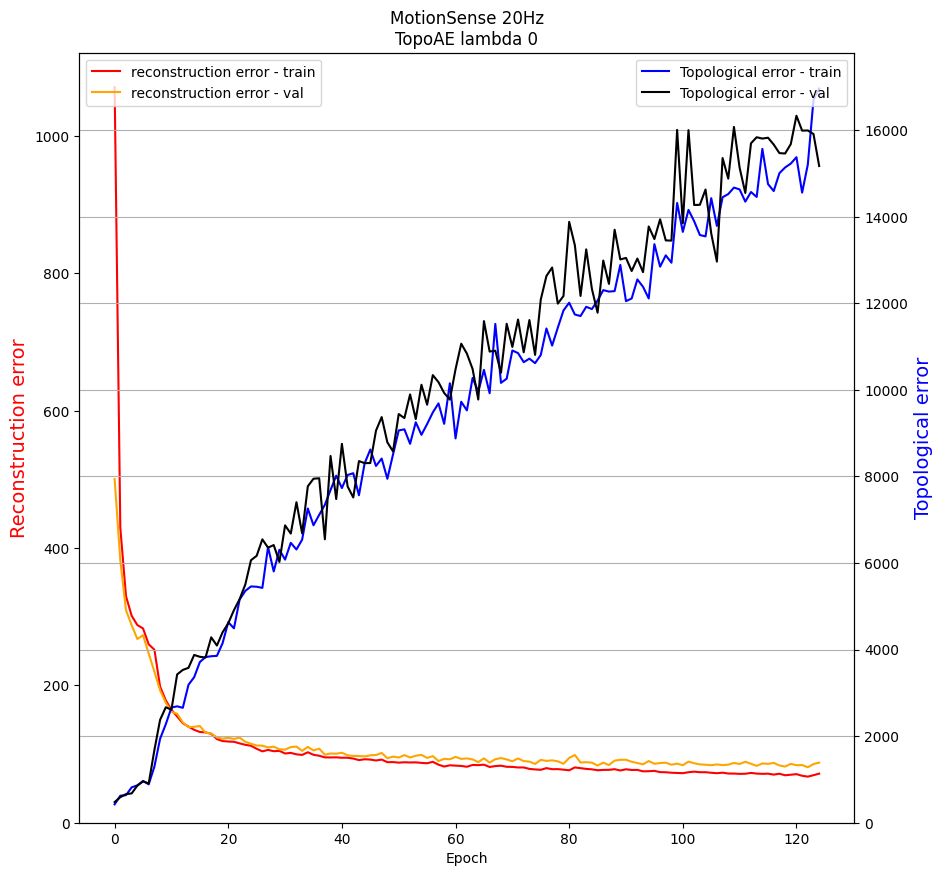

In [19]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [20]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [21]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [22]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8669607843137255,
 'RF-F1': 0.8634952169190905,
 'SVC-ACC': 0.8990196078431373,
 'SVC-F1': 0.8999084786138736,
 'KNN-ACC': 0.8382352941176471,
 'KNN-F1': 0.8378240683215271}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


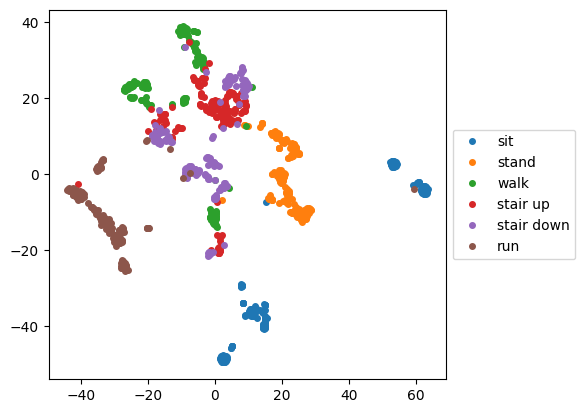

In [23]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=1)

In [24]:
model_lam = 1
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:771.2487, Loss-ae:745.8010, Loss-topo:25.4476
Epoch:2, P:None, Loss:726.2313, Loss-ae:717.2911, Loss-topo:8.9402
Epoch:3, P:None, Loss:621.8139, Loss-ae:606.2105, Loss-topo:15.6034
Epoch:4, P:None, Loss:423.4596, Loss-ae:406.4011, Loss-topo:17.0585
Epoch:5, P:None, Loss:359.4016, Loss-ae:348.6665, Loss-topo:10.7351
Epoch:6, P:None, Loss:325.2472, Loss-ae:317.8333, Loss-topo:7.4139
Epoch:7, P:None, Loss:331.8956, Loss-ae:321.3797, Loss-topo:10.5158
Epoch:8, P:None, Loss:312.6374, Loss-ae:305.9775, Loss-topo:6.6600
Epoch:9, P:None, Loss:305.3594, Loss-ae:297.9615, Loss-topo:7.3979
Epoch:10, P:None, Loss:297.5292, Loss-ae:291.0623, Loss-topo:6.4669
Epoch:11, P:None, Loss:305.1159, Loss-ae:298.0958, Loss-topo:7.0201
Epoch:12, P:None, Loss:289.2358, Loss-ae:283.7193, Loss-topo:5.5166
Epoch:13, P:None, Loss:295.8868, Loss-ae:289.8388, Loss-topo:6.0480
Epoch:14, P:None, Loss:287.5689, Loss-ae:282.1627, Loss-topo:5.4062
Epoch:15, P:None, Loss:281.3537, Loss-ae:275.8124, L

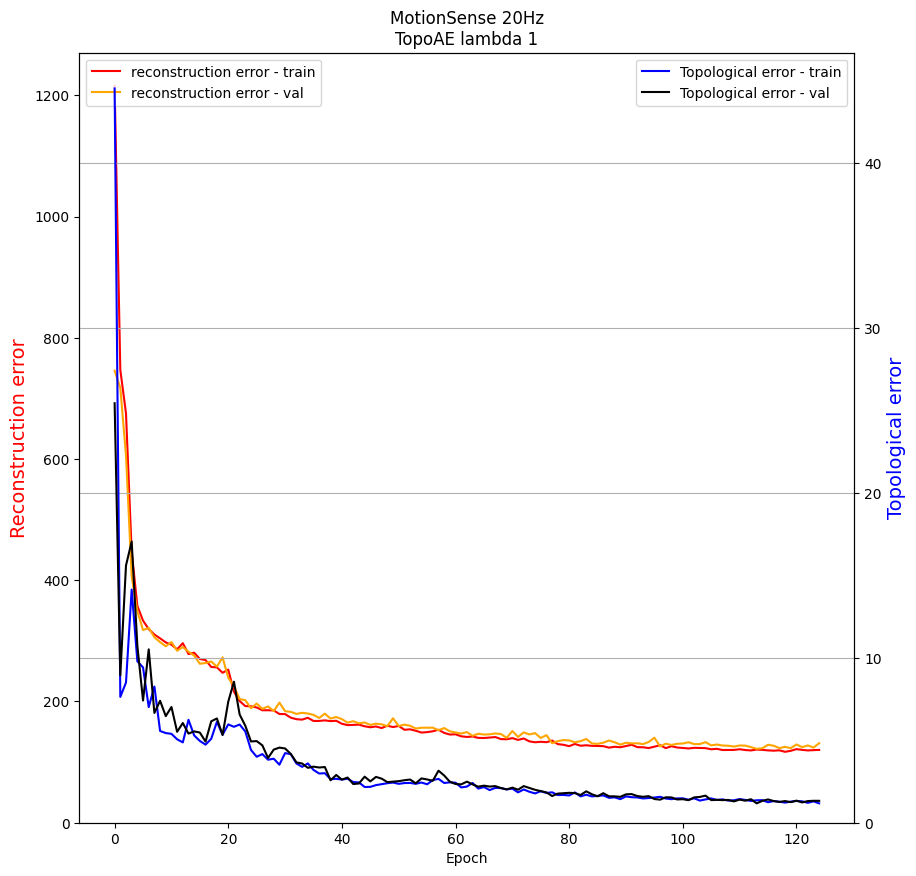

In [25]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [26]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [27]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [28]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8822549019607843,
 'RF-F1': 0.88164008105092,
 'SVC-ACC': 0.865686274509804,
 'SVC-F1': 0.8676974794270959,
 'KNN-ACC': 0.7911764705882353,
 'KNN-F1': 0.7884664952755538}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


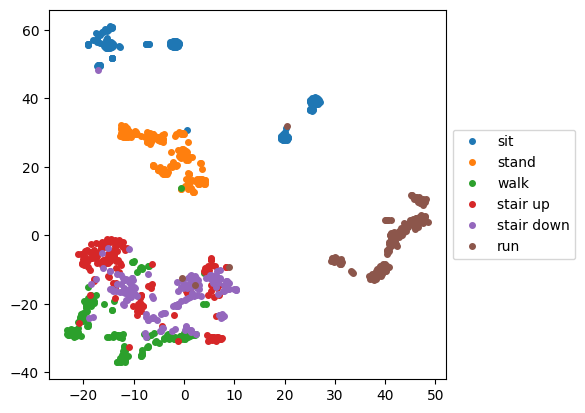

In [29]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=5)

In [30]:
model_lam = 5
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:871.1630, Loss-ae:839.2308, Loss-topo:6.3864
Epoch:2, P:None, Loss:724.2303, Loss-ae:712.9878, Loss-topo:2.2485
Epoch:3, P:None, Loss:721.6217, Loss-ae:714.5566, Loss-topo:1.4130
Epoch:4, P:None, Loss:695.5681, Loss-ae:689.5985, Loss-topo:1.1939
Epoch:5, P:None, Loss:708.9443, Loss-ae:702.9356, Loss-topo:1.2017
Epoch:6, P:None, Loss:698.8834, Loss-ae:695.4421, Loss-topo:0.6882
Epoch:7, P:None, Loss:700.6652, Loss-ae:696.0125, Loss-topo:0.9305
Epoch:8, P:None, Loss:579.4514, Loss-ae:559.8289, Loss-topo:3.9245
Epoch:9, P:None, Loss:383.9782, Loss-ae:370.3912, Loss-topo:2.7174
Epoch:10, P:None, Loss:367.7095, Loss-ae:360.9498, Loss-topo:1.3519
Epoch:11, P:None, Loss:348.0650, Loss-ae:341.9183, Loss-topo:1.2293
Epoch:12, P:None, Loss:346.9467, Loss-ae:340.1126, Loss-topo:1.3668
Epoch:13, P:None, Loss:334.8642, Loss-ae:329.2813, Loss-topo:1.1166
Epoch:14, P:None, Loss:325.6294, Loss-ae:320.0923, Loss-topo:1.1074
Epoch:15, P:None, Loss:322.7812, Loss-ae:318.3493, Loss-t

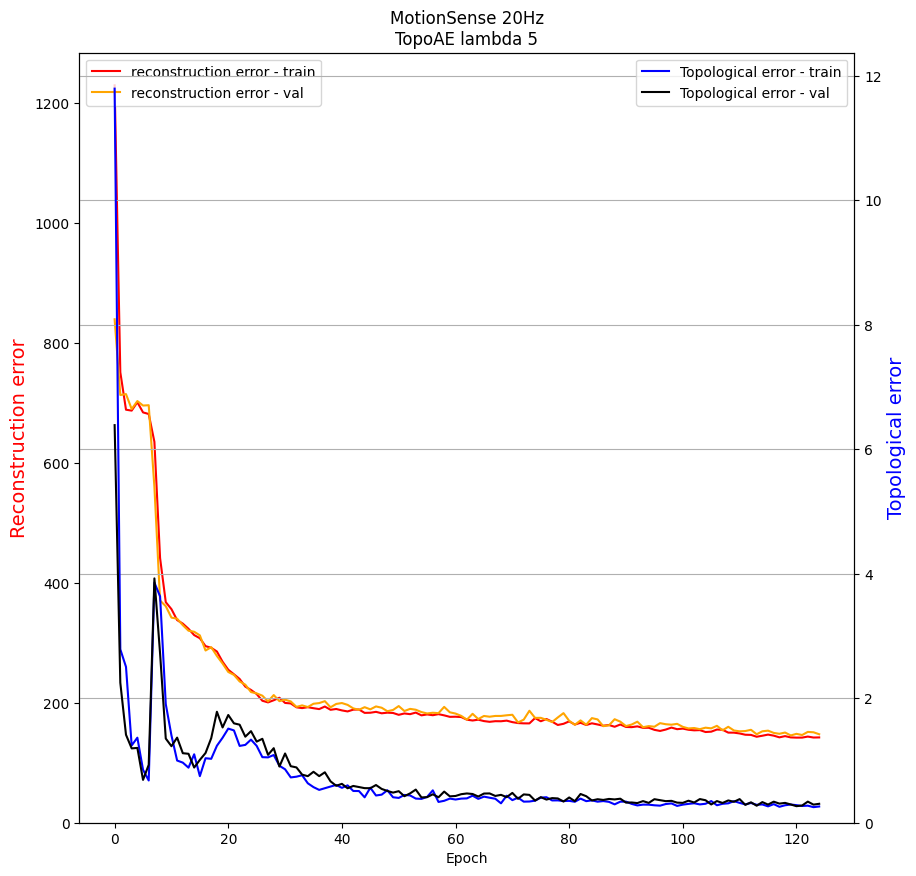

In [31]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [32]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [33]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [34]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8127450980392157,
 'RF-F1': 0.8069055937804874,
 'SVC-ACC': 0.8333333333333334,
 'SVC-F1': 0.8350483525048383,
 'KNN-ACC': 0.7745098039215687,
 'KNN-F1': 0.7719627494188959}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


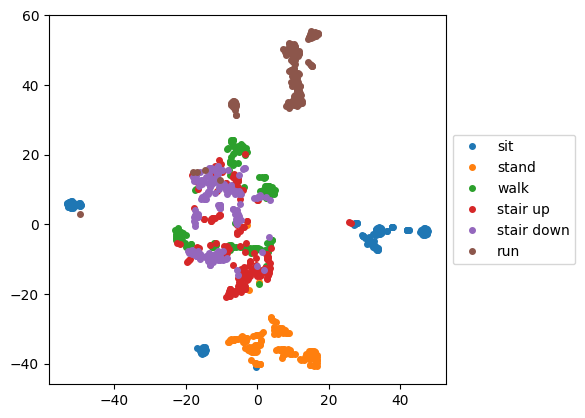

In [35]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=10)

In [36]:
model_lam = 10
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:824.6996, Loss-ae:810.1567, Loss-topo:1.4543
Epoch:2, P:None, Loss:723.8565, Loss-ae:715.2197, Loss-topo:0.8637
Epoch:3, P:None, Loss:707.2380, Loss-ae:699.6955, Loss-topo:0.7543
Epoch:4, P:None, Loss:671.8946, Loss-ae:661.1271, Loss-topo:1.0768
Epoch:5, P:None, Loss:705.8755, Loss-ae:701.8768, Loss-topo:0.3999
Epoch:6, P:None, Loss:672.9419, Loss-ae:668.0318, Loss-topo:0.4910
Epoch:7, P:None, Loss:674.9281, Loss-ae:671.6972, Loss-topo:0.3231
Epoch:8, P:None, Loss:629.9614, Loss-ae:614.1043, Loss-topo:1.5857
Epoch:9, P:None, Loss:499.4026, Loss-ae:484.4237, Loss-topo:1.4979
Epoch:10, P:None, Loss:354.7817, Loss-ae:345.2331, Loss-topo:0.9549
Epoch:11, P:None, Loss:348.0140, Loss-ae:340.7239, Loss-topo:0.7290
Epoch:12, P:None, Loss:322.1042, Loss-ae:315.8324, Loss-topo:0.6272
Epoch:13, P:None, Loss:320.7810, Loss-ae:314.3559, Loss-topo:0.6425
Epoch:14, P:None, Loss:312.8241, Loss-ae:307.3473, Loss-topo:0.5477
Epoch:15, P:None, Loss:293.1709, Loss-ae:286.8944, Loss-t

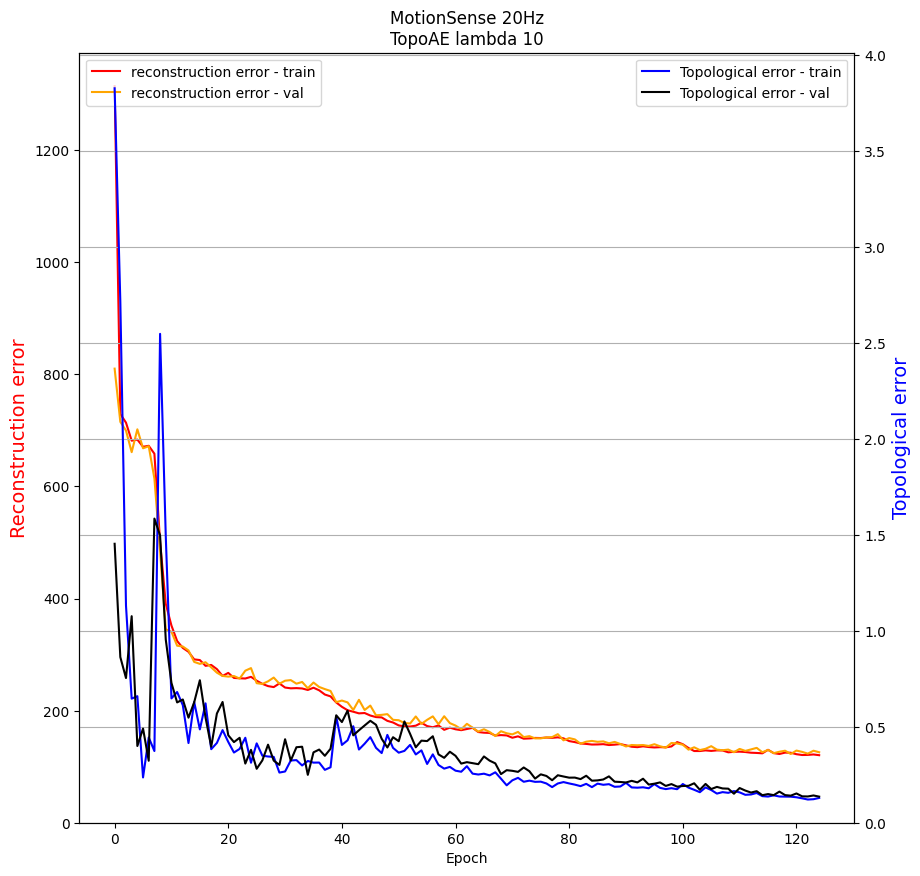

In [37]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [38]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [39]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [40]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8799019607843137,
 'RF-F1': 0.8800724129723335,
 'SVC-ACC': 0.8764705882352941,
 'SVC-F1': 0.879610928134836,
 'KNN-ACC': 0.8303921568627451,
 'KNN-F1': 0.8286890273921549}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


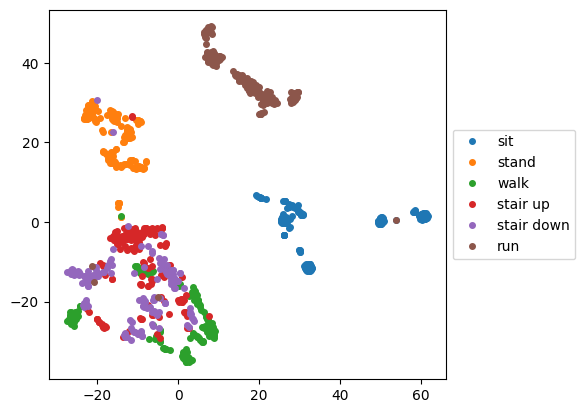

In [41]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

# Reducing with Topological Autoencoders (L=100)

In [42]:
model_lam = 100
topo_reducer = CustomTopoDimRedTransform(
    model_name='DeepAE_custom_dim2',
    model_lambda=model_lam,
    patience=None,
    num_epochs=model_epc,
    from_dim=180,
    to_dim=model_dim
)

Topologically Regularized DeepAE_custom_dim2
Using python to compute signatures
DeepAE_custom_dim, Input: (1, 180) Inner dim: 10


Epoch:1, P:None, Loss:1050.6254, Loss-ae:1031.3639, Loss-topo:0.1926
Epoch:2, P:None, Loss:745.3549, Loss-ae:724.9047, Loss-topo:0.2045
Epoch:3, P:None, Loss:733.6092, Loss-ae:722.7739, Loss-topo:0.1084
Epoch:4, P:None, Loss:740.6366, Loss-ae:734.8155, Loss-topo:0.0582
Epoch:5, P:None, Loss:726.4942, Loss-ae:716.7654, Loss-topo:0.0973
Epoch:6, P:None, Loss:745.2317, Loss-ae:742.4603, Loss-topo:0.0277
Epoch:7, P:None, Loss:708.1272, Loss-ae:705.1294, Loss-topo:0.0300
Epoch:8, P:None, Loss:718.6814, Loss-ae:712.6629, Loss-topo:0.0602
Epoch:9, P:None, Loss:722.4060, Loss-ae:708.0355, Loss-topo:0.1437
Epoch:10, P:None, Loss:714.0842, Loss-ae:708.0828, Loss-topo:0.0600
Epoch:11, P:None, Loss:490.3991, Loss-ae:474.5252, Loss-topo:0.1587
Epoch:12, P:None, Loss:397.5485, Loss-ae:391.3866, Loss-topo:0.0616
Epoch:13, P:None, Loss:381.1123, Loss-ae:371.5094, Loss-topo:0.0960
Epoch:14, P:None, Loss:358.1980, Loss-ae:354.2130, Loss-topo:0.0398
Epoch:15, P:None, Loss:365.8162, Loss-ae:360.7127, Loss

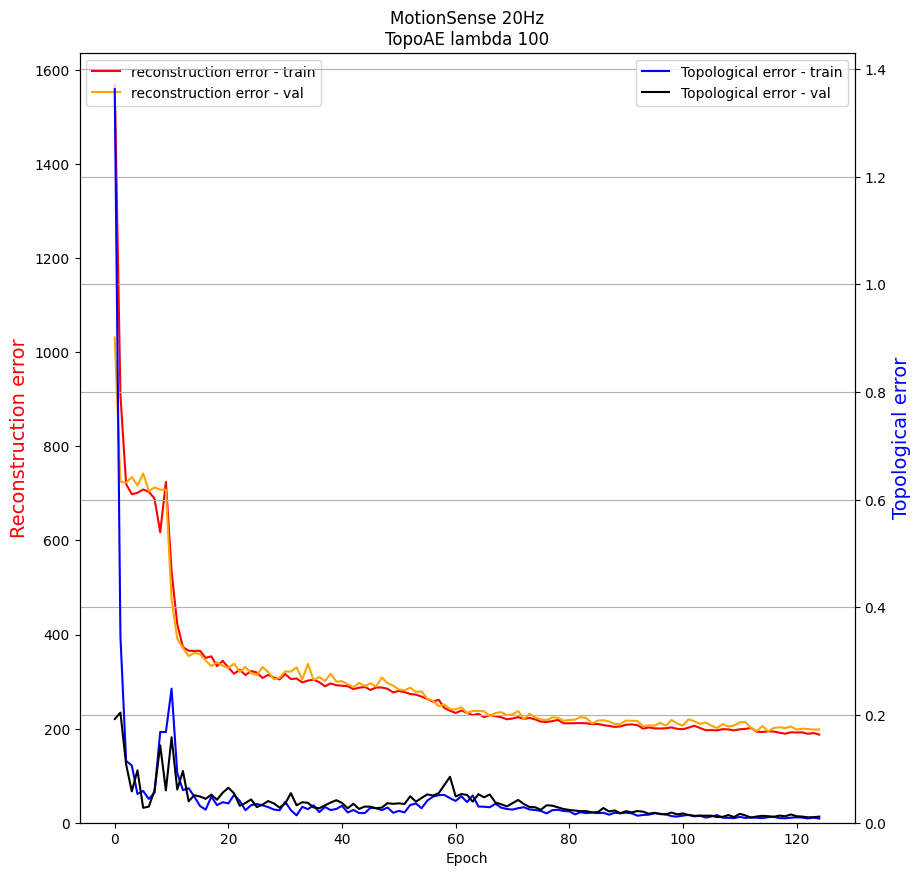

In [43]:
title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [44]:
train_LD = topo_reducer.transform(train_HD)
test_LD = topo_reducer.transform(test_HD)

In [45]:
train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
print('TRAIN LD RESHAPED', train_LD.shape)
test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
print('TEST LD RESHAPED', test_LD.shape)

TRAIN LD RESHAPED (4020, 10)
TEST LD RESHAPED (1020, 10)


In [46]:
experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
experiments_result

{'RF-ACC': 0.8178431372549019,
 'RF-F1': 0.8165131787923965,
 'SVC-ACC': 0.8333333333333334,
 'SVC-F1': 0.8389192315658496,
 'KNN-ACC': 0.7941176470588235,
 'KNN-F1': 0.7907284018934152}

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


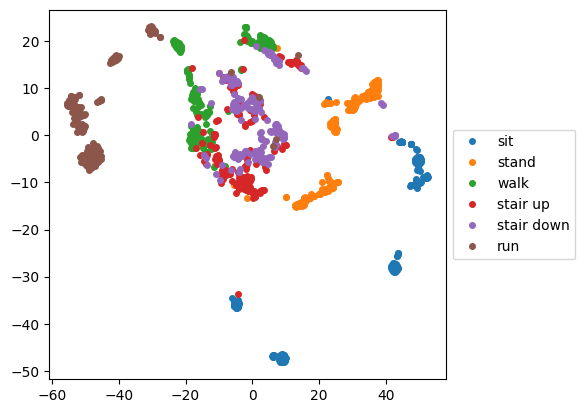

In [ ]:
# Visualizing
tsne = TSNE()
test_2D = tsne.fit_transform(test_LD)
visualize(test_2D, test_Y)

In [ ]:
# Reducing with Convolutional Topological Autoencoders

In [ ]:
# model_lam = 1
# model_dim = 10
# model_epc = 200
# topo_reducer = TopologicalDimensionalityReduction(
#     ae_model='ConvolutionalAutoencoder_custom_dim',
#     lam = model_lam,
#     ae_kwargs = {'input_dims':(1, 360), 'custom_dim':model_dim},
#     input_shape = (-1, 1, 1, 360),
#     patience = None,
#     num_epochs = model_epc
# )

In [ ]:
# title_plot = "MotionSense 20Hz\nTopoAE lambda {}".format(model_lam)
# topo_reducer.fit(train_HD, train_Y, title_plot=title_plot)

In [ ]:
# train_LD = topo_reducer.transform(train_HD)
# test_LD = topo_reducer.transform(test_HD)

In [ ]:
# train_LD = np.reshape(topo_reducer.transform(train_HD), (-1, model_dim))
# print('TRAIN LD RESHAPED', train_LD.shape)
# test_LD = np.reshape(topo_reducer.transform(test_HD), (-1, model_dim))
# print('TEST LD RESHAPED', test_LD.shape)

In [ ]:
# experiments_result = run_experiments(train_HD, train_LD, train_Y, test_HD, test_LD, test_Y)
# experiments_result